# CT reconstruction by Quantum Annealing

## Preparation

In [1]:
import cv2
import numpy as np
from tqdm.auto import tqdm

import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt

from skimage.data import shepp_logan_phantom

In [2]:
from dwave.system.samplers import LeapHybridSampler
from dwave.cloud import Client

import openjij as oj
import jijmodeling as jm
import jijmodeling_transpiler as jmt

In [3]:
use_leap = True
img_size = 20
label = "Binary CT reconstruction"

In [4]:
client = Client.from_config()
for s in client.get_solvers():
    print(s.id)

hybrid_binary_quadratic_model_version2
hybrid_discrete_quadratic_model_version1
hybrid_constrained_quadratic_model_version1
Advantage_system6.4
Advantage2_prototype2.3
Advantage_system4.1


In [5]:
rc = {
    "figure.dpi": 150,
    "figure.autolayout": False,
    "font.family": "sans-serif",
    "font.sans-serif": "Arial",
    "axes.titlesize": 16,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
}
sns.set_theme(context="notebook", style="white", rc=rc)

## Compute sinogram from Shepp-Logan phantom

In [6]:
# Load Shepp Logan phantom
image = shepp_logan_phantom()
image = image.astype("float32")
image = np.pad(image, ((56, 56), (56, 56)), mode="constant", constant_values=0)
print(image.shape, image.min(), image.max())

(512, 512) 0.0 1.0


In [7]:
# Shrink image to fit the number of qubits
image = cv2.resize(image, (img_size, img_size), interpolation=cv2.INTER_AREA)
image = (image - image.min()) / (image.max() - image.min())
print(image.shape)

(20, 20)


In [8]:
# binarize image
image = (image > 0.15).astype("float32")

In [9]:
# Make an image grid
H, W = image.shape
xs = np.arange(0, W)
ys = np.arange(0, H)
xs, ys = np.meshgrid(xs, ys)
ones = np.ones_like(xs)
grid = np.stack([xs, ys, ones], axis=-1)
grid = grid.astype("float32")

In [10]:
# Geometry
N = max(W, H)
angles = np.linspace(0.0, 2.0 * np.pi, N, endpoint=False)

In [11]:
# Compute sinogram
sino = []
for n, a in enumerate(angles):
    theta = np.rad2deg(a)
    rot = cv2.getRotationMatrix2D((W // 2, H // 2), theta, 1.0)
    rot_grid = cv2.warpAffine(
        grid,
        rot,
        (W, H),
        flags=cv2.INTER_LINEAR,
        borderMode=cv2.BORDER_CONSTANT,
        borderValue=9999,
    )

    proj = np.zeros(W)
    for j in range(W):
        for i in range(H):
            xp, yp = rot_grid[i, j, :2]
            if xp < 0 or xp >= W - 1 or yp < 0 or yp >= H - 1:
                continue

            xi, yi = int(xp), int(yp)
            xt, yt = xp - xi, yp - yi
            proj[j] += (1 - xt) * (1 - yt) * image[yi, xi]
            proj[j] += xt * (1 - yt) * image[yi, xi + 1]
            proj[j] += (1 - xt) * yt * image[yi + 1, xi]
            proj[j] += xt * yt * image[yi + 1, xi + 1]

    sino.append(proj)

sino = np.stack(sino, axis=0)

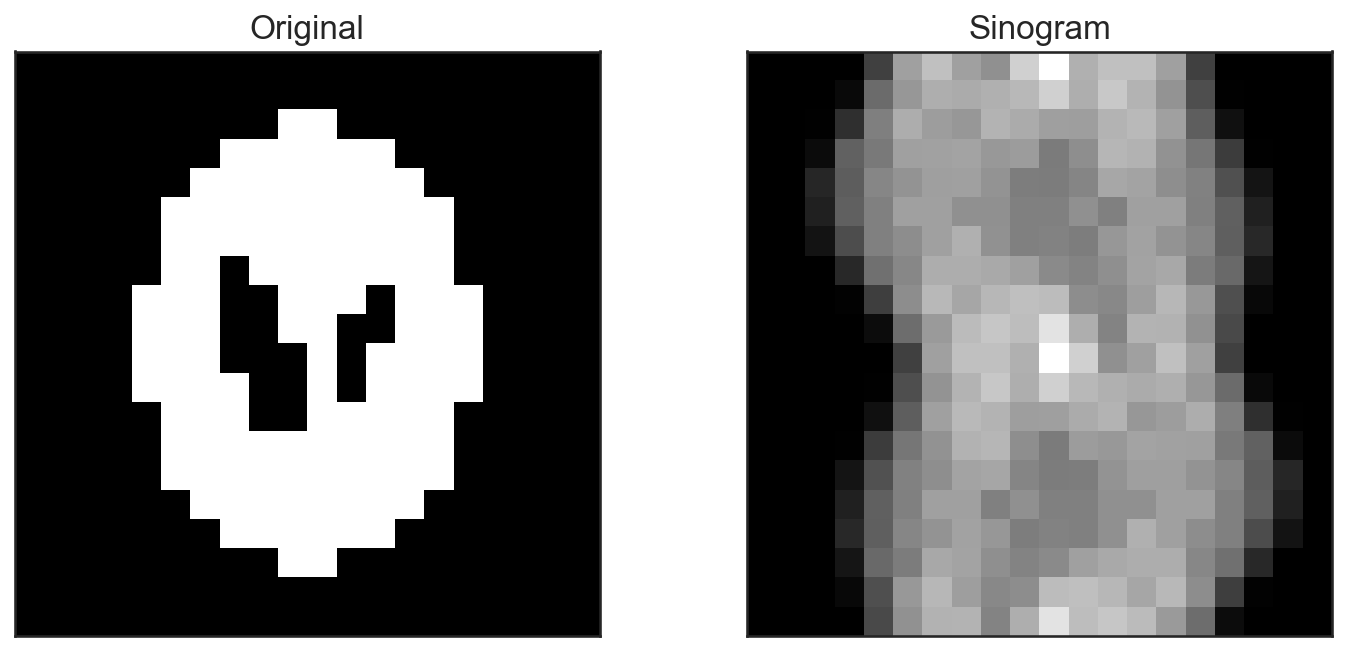

In [12]:
# Show CT image and corresponding sinogram
fig, axs = plt.subplots(1, 2, figsize=(10, 4.5))
axs[0].imshow(image, cmap="gray")
axs[0].set_title("Original")
axs[0].set(xticks=[], yticks=[])
axs[1].imshow(sino, cmap="gray")
axs[1].set_title("Sinogram")
axs[1].set(xticks=[], yticks=[])
plt.tight_layout()
plt.show()

## CT reconstruction with quantum annealing

In [13]:
# Binary variables
vars = jm.BinaryVar("x", shape=(H, W))

# Construct QUBO
H0 = 0.0
pbar = tqdm(total=len(angles) * W)
for n, a in enumerate(angles):
    theta = np.rad2deg(a)
    rot = cv2.getRotationMatrix2D((W // 2, H // 2), theta, 1.0)
    rot_grid = cv2.warpAffine(
        grid,
        rot,
        (W, H),
        flags=cv2.INTER_LINEAR,
        borderMode=cv2.BORDER_CONSTANT,
        borderValue=9999,
    )

    for j in range(W):
        val = 0.0
        for i in range(H):
            xp, yp = rot_grid[i, j, :2]
            if xp < 0 or xp >= W - 1 or yp < 0 or yp >= H - 1:
                continue

            xi, yi = int(xp), int(yp)
            xt, yt = xp - xi, yp - yi
            val += (1 - xt) * (1 - yt) * vars[yi, xi]
            val += xt * (1 - yt) * vars[yi, xi + 1]
            val += (1 - xt) * yt * vars[yi + 1, xi]
            val += xt * yt * vars[yi + 1, xi + 1]

        H0 += (val - sino[n, j]) ** 2
        pbar.update()

  0%|          | 0/400 [00:00<?, ?it/s]

In [14]:
# Make a OpenJij problem
problem = jm.Problem(label)
problem += H0

In [15]:
# Obtain a QUBO
compiled_model = jmt.core.compile_model(problem, {}, {})
pubo_builder = jmt.core.pubo.transpile_to_pubo(compiled_model)
qubo, const = pubo_builder.get_qubo_dict(multipliers={})

In [16]:
# Quantum annealing
if use_leap:
    print("Use D-Wave Leap")
    solver = LeapHybridSampler()
    res = solver.sample_qubo(qubo, label=label)
else:
    print("Use local computer")
    solver = oj.SASampler()
    res = solver.sample_qubo(qubo)

Use D-Wave Leap


In [17]:
sampleset = jmt.core.pubo.decode_from_openjij(res, pubo_builder, compiled_model)
sparse_index, value, _ = sampleset.record.solution["x"][0]

# Get reconstruction
rows, cols = zip(*sorted(zip(*sparse_index)))
pred = np.zeros((H, W), dtype="float32")
pred[rows, cols] = value

# Error
err = np.abs(image - pred)
rmse = np.sqrt(np.mean(err**2))

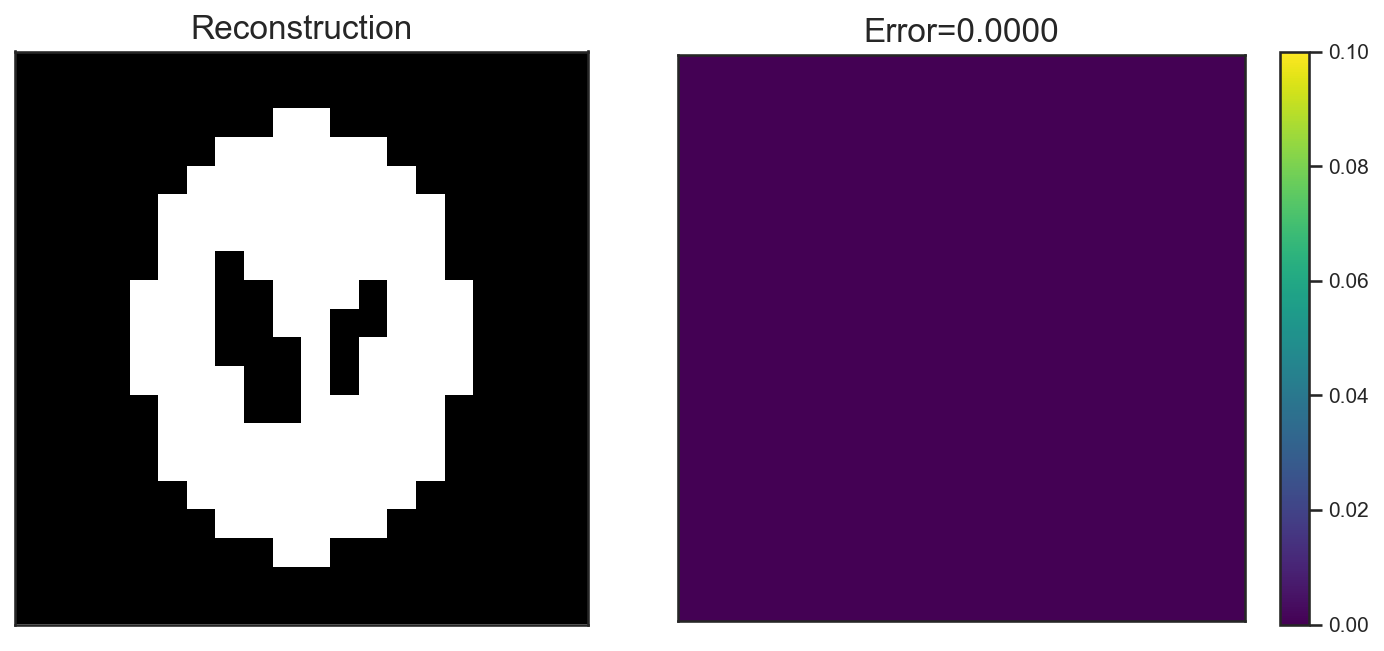

In [18]:
# Show result and error
fig, axs = plt.subplots(1, 2, figsize=(10, 4.5))
axs[0].imshow(pred, cmap="gray")
axs[0].set_title("Reconstruction")
axs[0].set(xticks=[], yticks=[])
ims_err = axs[1].imshow(err, vmin=0.0, vmax=0.1, cmap="viridis")
fig.colorbar(ims_err, ax=axs[1])
axs[1].set_title(f"Error={rmse:.4f}")
axs[1].set(xticks=[], yticks=[])
plt.tight_layout()
plt.show()